<a href="https://colab.research.google.com/github/wbandabarragan/EPIC_3/blob/main/Day_3/Materials_Science/Materials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycolt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.9 MB/s eta 0:00:00


In [2]:
import numpy as np
from colt import Colt
import random
from collections import namedtuple
from pandas import read_csv
import matplotlib.pyplot as plt

In [9]:
from google.colab import drive
drive.mount('/content/drive')


# To display the contents
#!ls "/content/drive/My Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
class Tully_1(Colt):

    _user_input = """
    # chosen parameters
    a = 0.01 :: float
    b = 1.6 :: float
    c = 0.005 :: float
    d = 1.0  :: float
    factor = 1.0  :: float
    """

    def __init__(self, a,b,c,d, factor):
        """ Tully model 1: Simple avoided crossing

            Diabatic potential, parameters:
            ------------------------------
                a: float
                b: float
                c: float
                d: float
           factor: float
        """
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.factor = factor

    def from_config(cls,config):
        return cls(config['a'], config['b'], config['c'], config['d'], config['factor'])

    def di_energy(self, x):
        """ returns the matrix of diabatic energies at position x """
        sign_a  = np.copysign(self.a,x)
        V_11 = sign_a*(1-np.exp(-self.b*np.abs(x)))
        V_22 = -V_11
        V_12 = self.c*np.exp(-self.d*(x**2))
        return np.array([ [V_11, V_12], [V_12, V_22] ])


    def di_gradient(self, x):
        """ returns the matrix of gradients of diabatic energies at position x """
        D_11 = self.a*self.b*np.exp(-self.b*np.abs(x))
        D_22 = -D_11
        D_12 = -self.d*(2*x)*self.c*np.exp(-self.d*(x**2))
        return np.array([ [D_11, D_12], [D_12, D_22] ])

    def energy(self, x):
        """ returns the matrix of adiabatic energies at position x """
        u_ij_di = self.di_energy(x)
        energies, coeff = np.linalg.eigh(u_ij_di)
        return energies

    def gradient(self, x):
        """ returns the matrix of adiabatic energies at position x """
        u_ij_di = self.di_energy(x)
        DV = self.di_gradient(x)
        energies, coeff = np.linalg.eigh(u_ij_di)

        gradients= np.dot(coeff.T, np.dot(DV, coeff))
        grad = np.diag(gradients)
        return grad


    def nac(self, x):
        """ returns the couplings at position x using np.linalg.eigh function.

            In Tully's paper, the Hamiltonian is expressed in a diabatic basis.
            If the diabatic basis is transformed into adiabatic basis, then
            the Hellmann-Feynman theorem:

                <\phi_i|d/dx|\phi_j> = <\phi_i|dH/dx|\phi_j>/(e_j - e_i),

            can be used to compute the nonadiabatic coupling strength (since,
            this theorem holds for the adiabatic basis).

            The diabatic basis (\psi_j) is related to the adiabatic basis (\phi_k) by
            the unitary tranformation:

                \psi_j = \sum_k \phi_k U_{k,j}

        """
        u_ij_di = self.di_energy(x)
        DV = self.di_gradient(x)
        energies, coeff = np.linalg.eigh(u_ij_di)

        dij= np.dot(coeff[:,0].T, np.dot(DV, coeff[:,1]))
        dE = energies[1] - energies[0]
        f = 50.0/self.factor
        return {(0,1): -dij/(f*dE), (1,0): dij/(f*dE)}

if __name__=="__main__":
    HO = Tully_1(a = 0.01, b = 1.6, c = 2, d = 0, factor = 1)
    #HO = Tully_1.from_questions(config = "model.inp")
    crd = 5
    print(HO.energy(crd))
    print(HO.gradient(crd))
    print(HO.nac(crd))

[-2.00002498  2.00002498]
[-2.68276723e-08  2.68276723e-08]
{(0, 1): 2.683633977376055e-08, (1, 0): -2.683633977376055e-08}


In [5]:
class VelocityVerletPropagator:

    def __init__(self,state):
        self.state = state
        self.t = state.t
        self.dt = state.dt
        self.crd = state.crd
        if self.crd < 0:
            self.x_min = self.crd
        elif self.state.crd > 0:
            self.x_min = -self.crd
        self.x_max = -self.x_min
        self.electronic = SurfaceHopping(self.state)
        self.results = PrintResults()

    def run(self):
        state = self.state
        results = self.results
        grad_old = self.electronic.setup(state)
        acce_old = self.accelerations(state, grad_old)
        results.print_head()
        while(self.x_min <= state.crd and state.crd <= self.x_max):
            """updating coordinates"""
            crd_new = self.positions(state, acce_old, self.dt)
            """updating accelerations"""
            grad_new = self.electronic.new_surface(state, results, crd_new, self.t, self.dt)
            acce_new = self.accelerations(state, grad_new)
            """updating velocities"""
            vel_new = self.velocities(state, acce_old, acce_new, self.dt)
            """updating variables"""
            acce_old = self.update_state(state, acce_new, crd_new, vel_new)
            self.t += self.dt
        results.print_bottom()

    def accelerations(self, state, grad):
        return -grad/state.mass

    def positions(self, state, a_0, dt):
        return state.crd + state.vel*dt + 0.5*a_0*dt**2

    def velocities(self, state, a_0, a_1, dt):
        return state.vel + 0.5*(a_0 + a_1)*dt

    def update_state(self, state, acce_new, crd_new, vel_new):
        state.crd = crd_new
        state.vel = vel_new
        acce_old = acce_new
        return acce_old

class RescaleVelocity:

    def __init__(self, state, ene_cou_grad):
        self.mass = state.mass
        self.state_old = state.instate
        self.ene_new = ene_cou_grad.ene
        self.nac_new = ene_cou_grad.nac
        self.nac_old = state.nac

    def diff_ji(self, state_new):
        return self.ene_new[self.state_old] - self.ene_new[state_new]

    def beta_ji(self, vel, direct):
        if np.isscalar(vel):
            return vel*direct
        else:
            return np.dot(vel.flatten(),direct.flatten())

    def alpha_ji(self, direct):
        if np.isscalar(self.mass):
            return 0.5*(direct**2)/self.mass
        else:
            alpha = 0.0
            for i, m in enumerate(self.mass):
                alpha += np.dot(direct[i], direct[i])/m
            return 0.5*alpha

    def new_velocity(self, state, gama_ji, direct):
        if np.isscalar(state.vel) and np.isscalar(self.mass):
            state.vel = state.vel - gama_ji*(direct/self.mass)
        else:
            for i, m in enumerate(self.mass):
                state.vel[i] = state.vel[i] - gama_ji*(direct[i]/m)

    def rescale_velocity(self, state, state_new):
        direct = (0.5)*(self.nac_old[state_new,self.state_old] + self.nac_new[state_new,self.state_old])
        diff = self.diff_ji(state_new)
        beta = self.beta_ji(state.vel, direct)
        alpha = self.alpha_ji(direct)
        if (beta**2 + 4*alpha*diff) < 0.0:
            """
            If this condition is satisfied, there is not hopping and
            then the nuclear velocity simply are reversed.
            """
            gama_ji = beta/alpha
            self.new_velocity(state, gama_ji, direct)
            hop = "not"
            return hop
        else:
            """
            If this condition is satisfied, a hopping from
            current state to the first true state takes place
            and the current nuclear velocity is ajusted in order
            to preserve the total energy.
            """
            if beta < 0.0:
                gama_ji = (beta + np.sqrt(beta**2 + 4*alpha*diff))/(2*alpha)
                self.new_velocity(state, gama_ji, direct)
            else:
                gama_ji = (beta - np.sqrt(beta**2 + 4*alpha*diff))/(2*alpha)
                self.new_velocity(state, gama_ji, direct)
            hop = "yes"
            return hop

class SurfaceHopping:

    def __init__(self, state):
        self.nstates = state.nstates
        self.mass = state.mass
        self.spp = Tully_1.from_questions(config = "model.inp")

    def elec_density(self, state):
        c_mch = state.ncoeff
        if isinstance(c_mch, np.ndarray) != True:
            c_mch = np.array(c_mch,dtype=np.complex128)
        return np.outer(c_mch, c_mch.conj())

    def get_gradient(self, crd, curr_state):
        result = self.spp.gradient(crd)
        return result[curr_state]

    def get_energy(self, crd):
        result = self.spp.energy(crd)
        return result

    def get_coupling(self, crd):
        result = self.spp.nac(crd)
        return result

    def cal_ekin(self, mass, vel):
        return 0.5*mass*vel**2

    def get_ene_cou_grad(self, crd, curr_state):
        h_mch = self.get_energy(crd)
        grad = self.get_gradient(crd, curr_state)
        ene, u = np.linalg.eigh(np.diag(h_mch))
        nac = self.get_coupling(crd)
        ene_cou_grad = namedtuple("ene_cou_grad", "ene u nac grad")
        return ene_cou_grad(ene, u, nac, grad)

    def vk_coupl_matrix(self, state):
        vel = state.vel
        nac = state.nac
        vk = np.zeros((self.nstates,self.nstates))
        for i in range(self.nstates):
            for j in range(self.nstates):
                if i < j:
                    vk[i,j] = vel*nac[i,j]
                    vk[j,i] = -vk[i,j]
        return vk

    def setup(self, state):
        ene_cou_grad = self.get_ene_cou_grad(state.crd, state.instate)
        grad_old = ene_cou_grad.grad
        state.ene = ene_cou_grad.ene
        state.epot = state.ene[state.instate]
        state.nac = ene_cou_grad.nac
        state.vk = self.vk_coupl_matrix(state)
        state.ekin = self.cal_ekin(state.mass, state.vel)
        state.rho = self.elec_density(state)
        return grad_old

    def mch_propagator(self, h_mch, vk, dt):
        h_total = np.diag(h_mch) - 1j*(vk)
        ene, u = np.linalg.eigh(h_total)
        p_mch = np.linalg.multi_dot([u, np.diag(np.exp( -1j * ene * dt)), u.T.conj()])
        return p_mch

    def elec_density_new(self, state,  rho_old, p_mch):
        """ Computing propagation and new density:
            D and U are diagonal and unitary matrices of hamiltonian
            rho_ij(t) = c_i(t)*c_j(t)^{*}
            as c(t+dt) = U*exp(-j*D*dt)*U.T*c(t),
            then rho_ij(t+dt) = c_i(t+dt)*c_j(t+dt)^{*}
                              = U*exp(-j*D*dt)*U.T*c_i(t)*c_j(t)^{*}*U*exp(j*D*dt)*U.T
                              = U*exp(-j*D*dt)*U.T*rho_ij(t)*U*exp(j*D*dt)*U.T
        """
        c_dt = np.linalg.multi_dot([p_mch, state.ncoeff])
        rho_new = np.linalg.multi_dot([p_mch, rho_old, p_mch.T.conj()])
        c_rho_new = namedtuple("c_rho_new", "c_dt rho_new")
        return c_rho_new(c_dt, rho_new)

    def probabilities(self, state, dt):
        rho_old = self.elec_density(state)
        instate = state.instate
        ene = state.ene
        vk = state.vk
        h_total = np.diag(ene) - 1j*(vk)
        p_mch = self.mch_propagator(ene, vk, dt)
        probs = (2.0 * np.imag(rho_old[instate,:] * h_total[:,instate]) * dt)/(np.real(rho_old[instate,instate]))
        probs[instate] = 0.0
        probs = np.maximum(probs, 0.0)
        tully = namedtuple("tully", "probs rho_old p_mch")
        return tully(probs, rho_old, p_mch)

    def new_prob_grad(self, state, ene_cou_grad, dt):
        tully = self.probabilities(state, dt)
        probs = tully.probs
        grad_new = ene_cou_grad.grad
        result = namedtuple("result","probs grad_new, tully")
        return result(probs, grad_new, tully)

    def surface_hopping(self, state, ene_cou_grad, probs):
        aleatory = random.uniform(0,1)
        acc_probs = np.cumsum(probs)
        total = np.sum(acc_probs)
        if total > 1.0:
            acc_probs /= total
        hopps = np.less(aleatory, acc_probs)
        if any(hopps):
            for i in range(self.nstates):
                if hopps[i]:
                    state_new = state.states[i]
                    break
            #else:
            #    state_new = state.instate
            rescale = RescaleVelocity(state, ene_cou_grad)
            hop =  rescale.rescale_velocity(state, state_new)
            if hop == "not":
                state_new = state.instate
        else:
            state_new = state.instate
        state.instate = state_new
        sur_hop = namedtuple("sur_hop", "aleatory acc_probs state_new")
        return sur_hop(aleatory, acc_probs[state_new], state_new)

    def new_ncoeff(self, state, grad_probs):
        c_rho_new = self.elec_density_new(state, grad_probs.tully.rho_old, grad_probs.tully.p_mch)
        state.rho = c_rho_new.rho_new
        state.ncoeff = c_rho_new.c_dt

    def new_surface(self, state, results, crd_new, t, dt):
        ene_cou_grad = self.get_ene_cou_grad(crd_new, state.instate)
        grad_probs = self.new_prob_grad(state, ene_cou_grad, dt)
        old_state = state.instate
        sur_hop = self.surface_hopping(state, ene_cou_grad, grad_probs.probs)
        state.ekin = self.cal_ekin(state.mass, state.vel)
        state.ene = ene_cou_grad.ene
        state.epot = state.ene[state.instate]
        results.print_var(t, dt, sur_hop, state) #printing variables
        self.new_ncoeff(state, grad_probs)
        state.nac = ene_cou_grad.nac
        state.vk = self.vk_coupl_matrix(state)
        if old_state == sur_hop.state_new:
            return grad_probs.grad_new
        else:
            return self.get_gradient(crd_new, state.instate)

class PrintResults:

    def __init__(self):
        self.results = open("results.out", "w")

    def norm_coeff(self, ncoeff):
        if isinstance(ncoeff, np.ndarray) != True:
            ncoeff = np.array(ncoeff)
        return np.diag(np.outer(ncoeff, ncoeff.conj()).real)

    def print_head(self):
        head = namedtuple("head","t crd vel ekin ene_0 ene_1 epot etotal coff_0 coff_1 prob random state")
        head = head("time", "crd", "vel", "ekin", "ene_0", "ene_1", "epot", "etotal", "coff_0", "coff_1", "prob", "random", "state")
        self.results.write(f"{head.t},{head.crd},{head.vel},{head.ekin},"\
                    f"{head.ene_0},{head.ene_1},{head.epot},{head.etotal},{head.coff_0},{head.coff_1},{head.prob},{head.random},{head.state}\n")

    def print_var(self, t, dt, sur_hop, state):
        var = namedtuple("head","t crd vel ekin ene_0 ene_1 epot etotal coff_0 coff_1 prob random state")
        var = var(t,state.crd,state.vel,state.ekin,state.ene[0],state.ene[1],state.epot,state.ekin + state.epot,\
                    self.norm_coeff(state.ncoeff)[0],self.norm_coeff(state.ncoeff)[1],sur_hop.acc_probs,sur_hop.aleatory,state.instate)
        self.results.write(f"{var.t:>0.3f},{var.crd:>0.8f},{var.vel:>0.8f},{var.ekin:>0.8f},{var.ene_0:>0.8f},{var.ene_1:>0.8f},{var.epot:>0.8f},"\
                    f"{var.etotal:>0.8f},{var.coff_0:>0.8f},{var.coff_1:>0.8f},{var.prob:>0.8f},{var.random:>0.8f},{var.state:>0.0f}\n")

    def print_bottom(self):
        self.results.close()


class State(Colt):

    _user_input = """
    # chosen parameters
    crd = 10.0 :: float
    vel = 2 :: float
    mass = 2000.0 :: float
    t = 0.0 :: float
    dt = 1.0 :: float
    mdsteps = 40000 :: float
    instate = 1 :: int
    nstates = 2 :: int
    states = 0 1 :: ilist
    ncoeff = 0.0 1.0 :: flist
    """


    def __init__(self, crd, vel, mass, t, dt, mdsteps, instate, nstates, states, ncoeff):
        self.crd = crd
        self.vel = vel
        self.mass = mass
        self.t = t
        self.dt = dt
        self.mdsteps = mdsteps
        self.instate = instate
        self.nstates = nstates
        self.states = states
        self.ncoeff = ncoeff
        self.ekin = 0
        self.epot = 0
        self.nac = {}
        self.ene = []
        self.vk = []
        self.rho = []

    @classmethod
    def from_config(cls, config):
        crd = config['crd']
        vel = config['vel']
        mass = config['mass']
        t = config['t']
        dt = config['dt']
        mdsteps = config['mdsteps']
        instate = config['instate']
        nstates = config['nstates']
        states = config['states']
        ncoeff = config['ncoeff']
        return cls(crd, vel, mass, t, dt, mdsteps, instate, nstates, states, ncoeff)

if __name__=="__main__":
    elec_state = State.from_questions(config = "prop.inp")
    DY = VelocityVerletPropagator(elec_state)
    try:
        result = DY.run()
    except SystemExit as err:
        print("An error:", err)

chosen parameters
crd [10.0]: 
vel [2.0]: 
mass [2000.0]: 
t [0.0]: 
dt [1.0]: 
mdsteps [40000.0]: 
instate [1]: 
nstates [2]: 
states [[0, 1]]: 
ncoeff [[0.0, 1.0]]: 
chosen parameters
a [0.01]: 
b [1.6]: 
c [0.005]: 
d [1.0]: 
factor [1.0]: 


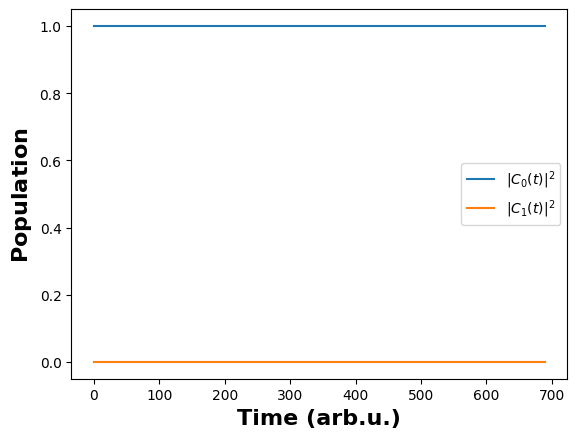

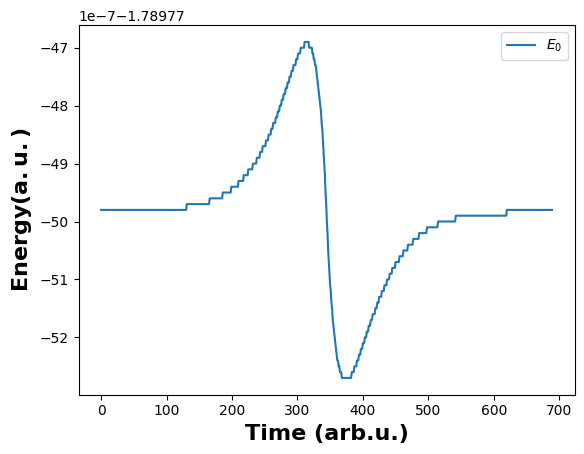

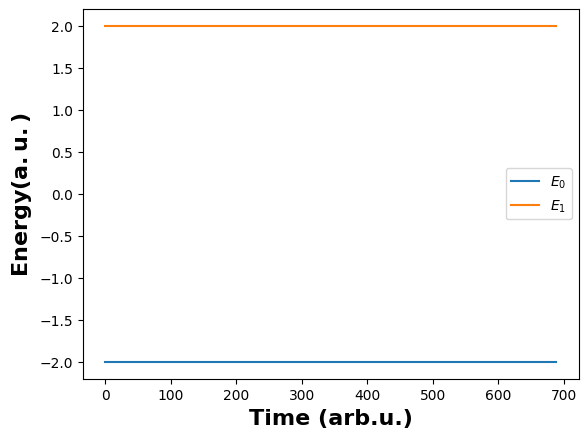

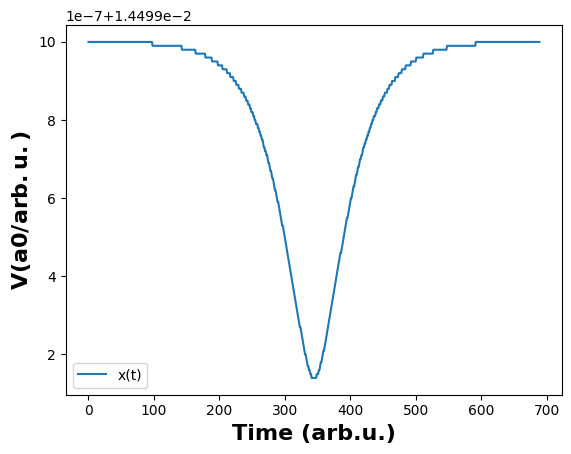

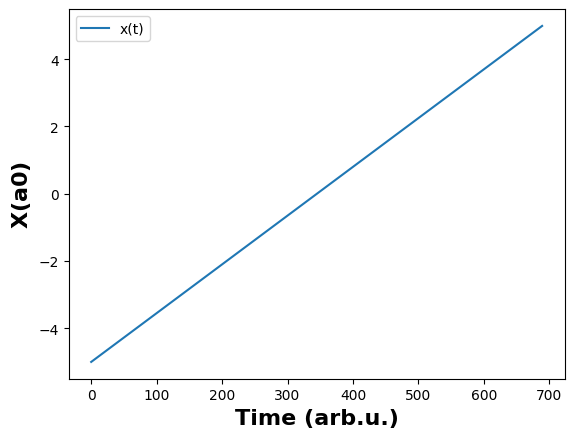

In [8]:
class PlotResults:

    def __init__(self, output):
        self.output = read_csv(output)

    def plot_position(self):
        plt.plot(self.output.time,self.output.crd, label = 'x(t)')
        for i in range(self.output.shape[0]-1):
            if self.output.state[i] != self.output.state[i+1]:
                plt.axvline(x=self.output.time[i+1],label='Hop. at %i'%self.output.time[i+1],\
                            linestyle='--', c = 'purple')
        plt.xlabel('Time (arb.u.)', fontweight = 'bold', fontsize = 16)
        plt.ylabel('$\mathbf{X(a0)}$', fontsize = 16)
        plt.legend()
        plt.show()
        #plt.savefig("position.pdf", bbox_inches='tight')
        plt.close()

    def plot_velocity(self):
        plt.plot(self.output.time,self.output.vel, label = 'x(t)')
        for i in range(self.output.shape[0]-1):
            if self.output.state[i] != self.output.state[i+1]:
                plt.axvline(x=self.output.time[i+1],label='Hop. at %i'%self.output.time[i+1],\
                            linestyle='--', c = 'purple')
        plt.xlabel('Time (arb.u.)', fontweight = 'bold', fontsize = 16)
        plt.ylabel('$\mathbf{V(a0/arb.u.)}$', fontsize = 16)
        plt.legend()
        plt.show()
        #plt.savefig("velocity.pdf", bbox_inches='tight')
        plt.close()

    def plot_total_energies(self):
        plt.plot(self.output.time,self.output.etotal, label = '$E_0$')
        for i in range(self.output.shape[0]-1):
            if self.output.state[i] != self.output.state[i+1]:
                plt.axvline(x=self.output.time[i+1],label='Hop. at %i'%self.output.time[i+1],\
                            linestyle='--', c = 'purple')
        plt.xlabel('Time (arb.u.)', fontweight = 'bold', fontsize = 16)
        plt.ylabel('$\mathbf{Energy(a.u.)}$', fontsize = 16)
        plt.legend()
        plt.show()
        #plt.savefig("total_energies.pdf", bbox_inches='tight')
        plt.close()

    def plot_energies(self):
        plt.plot(self.output.time,self.output.ene_0, label = '$E_0$')
        plt.plot(self.output.time,self.output.ene_1, label = '$E_1$')
        for i in range(self.output.shape[0]-1):
            if self.output.state[i] != self.output.state[i+1]:
                plt.axvline(x=self.output.time[i+1],label='Hop. at %i'%self.output.time[i+1],\
                            linestyle='--', c = 'purple')
        plt.xlabel('Time (arb.u.)', fontweight = 'bold', fontsize = 16)
        plt.ylabel('$\mathbf{Energy(a.u.)}$', fontsize = 16)
        plt.legend()

        plt.show()
        #plt.savefig("energies.pdf", bbox_inches='tight')
        plt.close()

    def plot_population(self):
        plt.plot(self.output.time,self.output.coff_0, label = '$|C_0(t)|^2$')
        plt.plot(self.output.time,self.output.coff_1, label = '$|C_1(t)|^2$')
        for i in range(self.output.shape[0]-1):
            if self.output.state[i] != self.output.state[i+1]:
                plt.axvline(x=self.output.time[i+1],label='Hop. at %i'%self.output.time[i+1],\
                            linestyle='--', c = 'purple')
        plt.xlabel('Time (arb.u.)', fontweight = 'bold', fontsize = 16)
        plt.ylabel('$\mathbf{Population}$', fontsize = 16)
        plt.legend()
        plt.show()
        #plt.savefig("population.pdf", bbox_inches='tight')
        plt.close()

if __name__=="__main__":

    output = "/content/drive/My Drive/Colab Notebooks/results.out"
    picture = PlotResults(output)
    picture.plot_population()
    picture.plot_total_energies()
    picture.plot_energies()
    picture.plot_velocity()
    picture.plot_position()